In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#statistic
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

# Ignore FutureWarning warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
df=pd.read_csv('/Users/candicewu/Desktop/cleaned_dataset.csv')
df

,price_log,city,condition,grade,view,floors,bedrooms,bathrooms,sqft_living_log,sqft_lot_log,house_age,school_rate,unemployment_rate,travel_time_to_work,total_population,typical_levy_rate,median_age,median_household_income,area_crime
0,5.640978,Issaquah,4,9,0,2.0,3,2.25,3.294466,4.545307,46,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
1,5.799341,Issaquah,3,9,0,2.0,4,2.75,3.432969,4.571441,23,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
2,5.579646,Issaquah,4,7,0,1.0,3,2.50,3.217484,4.147800,37,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
3,5.720893,Issaquah,5,7,0,1.0,5,1.75,3.406540,4.856572,63,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
4,5.612784,Issaquah,4,8,0,1.0,3,2.25,3.255273,4.564713,45,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20547,6.217747,Medina,3,9,0,1.0,4,3.25,3.561101,4.131298,99,0.991565,0.022,19.8,3120.0,0.0872,45.4,174063.0,75.0
20548,6.079181,Medina,3,8,0,2.0,4,3.00,3.332438,3.909503,70,0.991565,0.022,19.8,3120.0,0.0872,45.4,174063.0,75.0
20549,6.410777,Medina,4,10,0,1.0,5,3.00,3.679428,4.310481,48,0.991565,0.022,19.8,3120.0,0.0872,45.4,174063.0,75.0
20550,6.352183,Medina,3,11,0,2.0,5,5.25,3.532754,3.909449,17,0.991565,0.022,19.8,3120.0,0.0872,45.4,174063.0,75.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20552 entries, 0 to 20551
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_log                20552 non-null  float64
 1   city                     20552 non-null  object 
 2   condition                20552 non-null  int64  
 3   grade                    20552 non-null  int64  
 4   view                     20552 non-null  int64  
 5   floors                   20552 non-null  float64
 6   bedrooms                 20552 non-null  int64  
 7   bathrooms                20552 non-null  float64
 8   sqft_living_log          20552 non-null  float64
 9   sqft_lot_log             20552 non-null  float64
 10  house_age                20552 non-null  int64  
 11  school_rate              20552 non-null  float64
 12  unemployment_rate        20552 non-null  float64
 13  travel_time_to_work      20552 non-null  float64
 14  total_population      

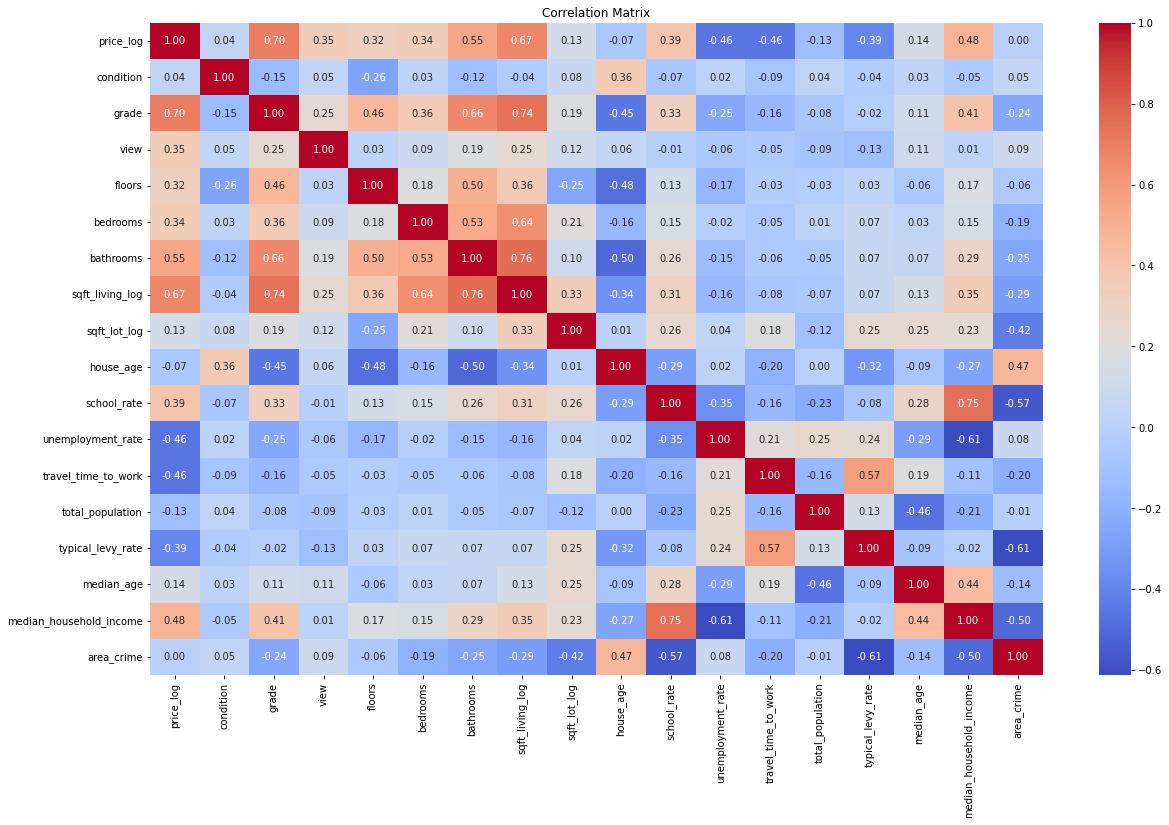

In [4]:
# Displaying correlation matrix with a heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Step 2: modeling


#### MLR Method


https://medium.com/codex/step-by-step-guide-to-simple-and-multiple-linear-regression-in-python-867ac9a30298

##### 1. OLS model

In [5]:
X = df[['condition','grade','floors','view', 'bedrooms', 'bathrooms', 
       'sqft_living_log', 'sqft_lot_log', 'house_age', 'school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
y = df['price_log']

# Add intercept term
X = sm.add_constant(X)

# Fit model
model1 = sm.OLS(y, X).fit()

# Print summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     5598.
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        14:12:54   Log-Likelihood:                 19073.
No. Observations:               20552   AIC:                        -3.811e+04
Df Residuals:                   20534   BIC:                        -3.797e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

##### Regression Diagnostics
https://www.geeksforgeeks.org/residual-leverage-plot-regression-diagnostic/</p>
https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

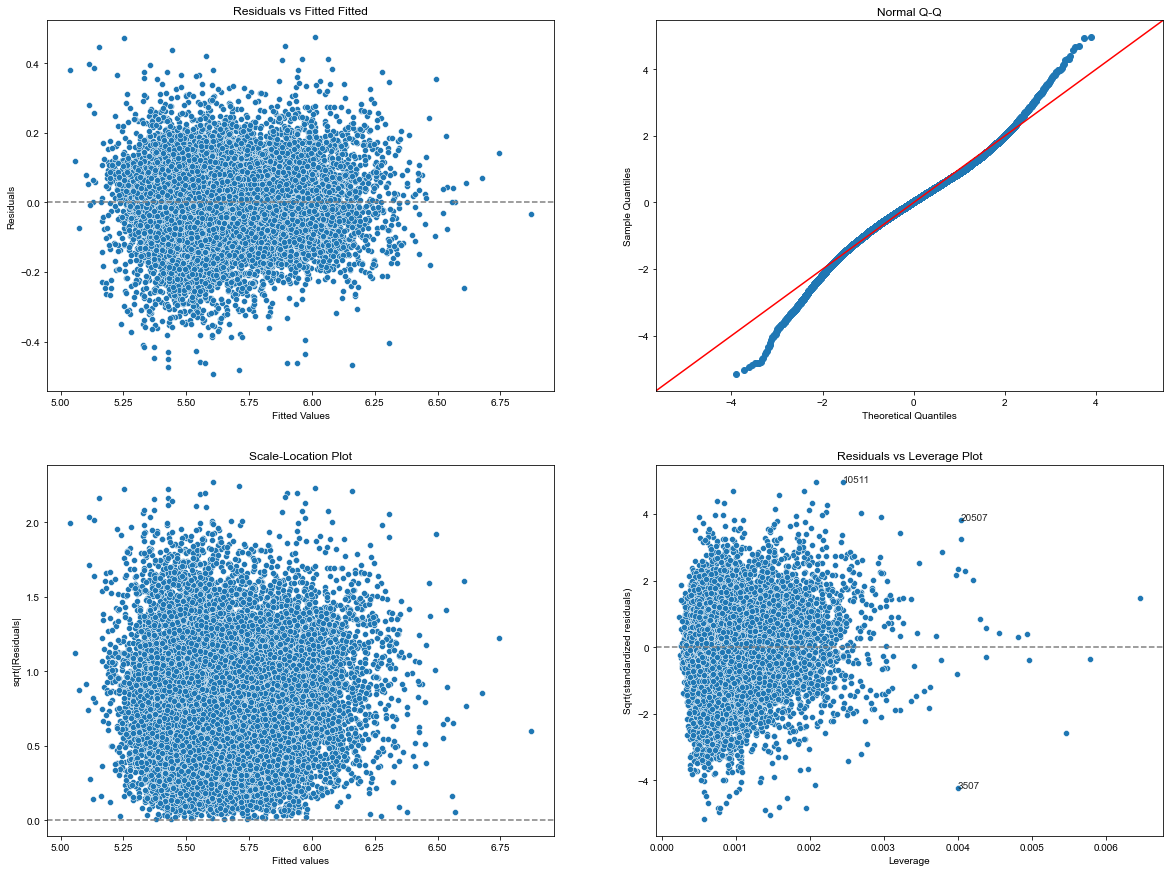

In [6]:
# Get different Variables for diagnostic
fitted_value = model1.fittedvalues #model values
residuals = model1.resid #model residuals
stand_residuals = model1.get_influence().resid_studentized_internal #standardized residuals
stand_residuals_abs_sqrt = np.sqrt(np.abs(stand_residuals)) #absolute squared standardized residuals
abs_resid = np.abs(residuals) #absolute residuals
influence = model1.get_influence()
leverage = influence.hat_matrix_diag #leverage, from statmodels intervals
cooks_distance= model1.get_influence().cooks_distance[0]

# Plot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)

sns.set_style('whitegrid')

# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')

# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45', ax=ax[0, 1])
ax[0, 1].set_title('Normal Q-Q')

# Scale-Location Plot
#https://www.statology.org/scale-location-plot/
#A scale-location plot is a type of plot that displays the fitted values of a regression model along the x-axis and the the square root of the standardized residuals along the y-axis.
sns.scatterplot(x=fitted_value, y=stand_residuals_abs_sqrt, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('sqrt(|Residuals|')
ax[1, 0].set_title('Scale-Location Plot')

# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_residuals, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')
# annotations
leverage_top_3 = np.flip(np.argsort(cooks_distance), 0)[:3]
for i in leverage_top_3:
   ax[1, 1].annotate(i, xy=(leverage[i], stand_residuals[i]))
    
plt.show()


It’s important to note that Cook’s Distance should be used as a way to identify potentially influential observations. Just because an observation is influential doesn’t necessarily mean that it should be deleted from the dataset.</p>
Therefore, we should verify that the observation isn’t a result of a data entry error or some other odd occurrence. If it turns out to be a legit value, we can then decide if it’s appropriate to delete it, leave it be, or simply replace it with an alternative value like the median.</p>
https://www.statology.org/cooks-distance-python/#:~:text=The%20larger%20the%20value%20for,considered%20to%20be%20highly%20influential.

##### 2.Scikit-learn

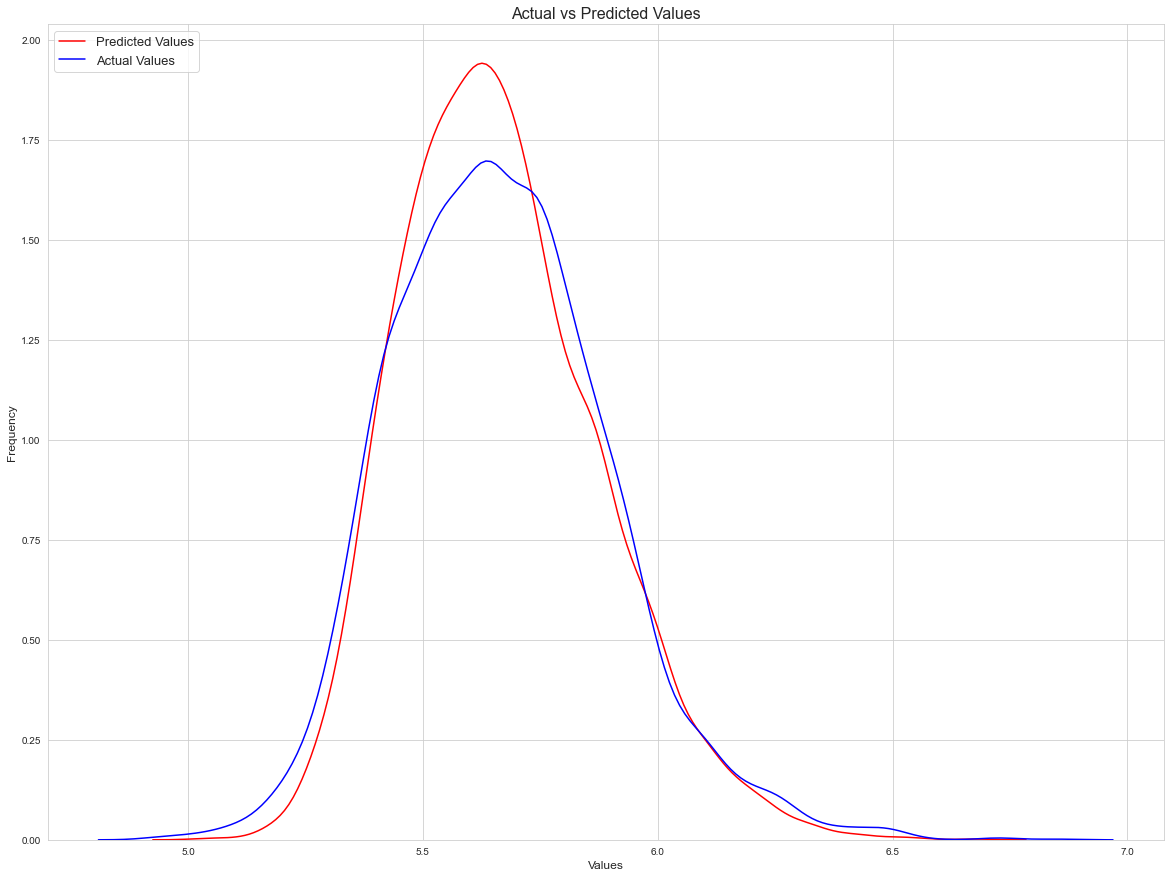

In [7]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

# Visualizing Prediction Accuracy
sns.kdeplot(y_pred, color = 'r', label = 'Predicted Values')
sns.kdeplot(y_test, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [8]:
#https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))#https://www.rasgoml.com/feature-engineering-tutorials/how-to-calculate-r-2-with-scikit-learn

MAE:  0.07150334788704411
MSE:  0.008891732773480201
RMSE:  0.26740109926296884
R-Squared : 0.830936254544536


##### 3. model improvement
https://towardsdatascience.com/identifying-outliers-in-linear-regression-cooks-distance-9e212e9136a

In [9]:
#Determine the threshold
threshold = 4 / (len(df) - len(X.columns) - 1)
#any data point with a Cook’s Distance greater than 4/n (where n is the total number of observations) is flagged 
# as an ‘observation of interest’ that is worthy of closer scrutiny.

#Identify outliers
outlier_indices = np.where(cooks_distance > threshold)[0]

#Remove outliers
df_cleaned = df.reset_index(drop=True).drop(outlier_indices)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19249 entries, 0 to 20551
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_log                19249 non-null  float64
 1   city                     19249 non-null  object 
 2   condition                19249 non-null  int64  
 3   grade                    19249 non-null  int64  
 4   view                     19249 non-null  int64  
 5   floors                   19249 non-null  float64
 6   bedrooms                 19249 non-null  int64  
 7   bathrooms                19249 non-null  float64
 8   sqft_living_log          19249 non-null  float64
 9   sqft_lot_log             19249 non-null  float64
 10  house_age                19249 non-null  int64  
 11  school_rate              19249 non-null  float64
 12  unemployment_rate        19249 non-null  float64
 13  travel_time_to_work      19249 non-null  float64
 14  total_population         19

In [10]:
X_cleaned = df_cleaned[['condition','grade','floors','view', 'bedrooms', 'bathrooms',
       'sqft_living_log', 'sqft_lot_log', 'house_age', 'school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
y_cleaned = df_cleaned['price_log']

# Add intercept term
X_cleaned = sm.add_constant(X_cleaned)

# Fit model
cleaned_model1 = sm.OLS(y_cleaned, X_cleaned).fit()

# Print summary
print(cleaned_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     7321.
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        14:12:57   Log-Likelihood:                 22056.
No. Observations:               19249   AIC:                        -4.408e+04
Df Residuals:                   19231   BIC:                        -4.393e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [11]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.3, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))

MAE:  0.06163015055863139
MSE:  0.005934198412897345
RMSE:  0.2482542055205337
R-Squared : 0.8664885373622279
